In [2]:
import numpy as np
import networkx as nx
import pandas as pd

from scipy import stats

# import causalpy as cp

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import torch
import pytorch_lightning as pl

from catenets.models.torch import TARNet, SNet, FlexTENet
from models.causal_bert_pytorch.CausalBert import CausalBertWrapper

from econml.metalearners import SLearner, XLearner
from econml.dml import CausalForestDML
from econml.dr import LinearDRLearner
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/Users/IFLM/anaconda3/envs/causal_book_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/IFLM/anaconda3/envs/causal_book_py39/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/IFLM/anaconda3/envs/causal_book_py39/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numb

In [3]:
# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [4]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [5]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

# Chapter 11.1

In [6]:
# Set random seed
SEED = 18
np.random.seed(SEED)
pl.seed_everything(SEED)  

Global seed set to 18


## Going Deeper: Deep Learning for Heterogenous Treatment Effects

### Data

In [7]:
SAMPLE_SIZE = 5000
TRAIN_SIZE = 4500
N_FEATURES = 20

X = np.random.normal(0, 1, (SAMPLE_SIZE, N_FEATURES))
T = np.random.binomial(1, 0.5, SAMPLE_SIZE)

weights = np.random.gumbel(5, 10, (SAMPLE_SIZE, N_FEATURES - 1))

y = (50 * T * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)

y0 = (50 * 0 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)
y1 = (50 * 1 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)


In [8]:
effect_true = y1[TRAIN_SIZE:] - y0[TRAIN_SIZE:] 

### S-Learner, X-Learner, DR-Learner & Causal Forest (Benchmark)

In [9]:
benchmark_models = {
    'SLearner': SLearner(overall_model=LGBMRegressor()),
    'XLearner': XLearner(models=LGBMRegressor()),
    'DRLearner': LinearDRLearner(),
    'CausalForest': CausalForestDML()
}

benchmark_results = {}


for model_name, model in benchmark_models.items():
    model.fit(
        X=X[:TRAIN_SIZE, :],
        T=T[:TRAIN_SIZE],
        Y=y[:TRAIN_SIZE]
    )

    effect_pred = model.effect(
        X[TRAIN_SIZE:]
    )
    
    benchmark_results[model_name] = effect_pred

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5104
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 22
[LightGBM] [Info] Start training from score 20.369942


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2278, number of used features: 20
[LightGBM] [Info] Start training from score 0.420480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2222, number of used features: 20
[LightGBM] [Info] Start training from score 40.822181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2278, number of used features: 20
[LightGBM] [Info] Start train

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


SLearner MAPE = 3.3391135090997492


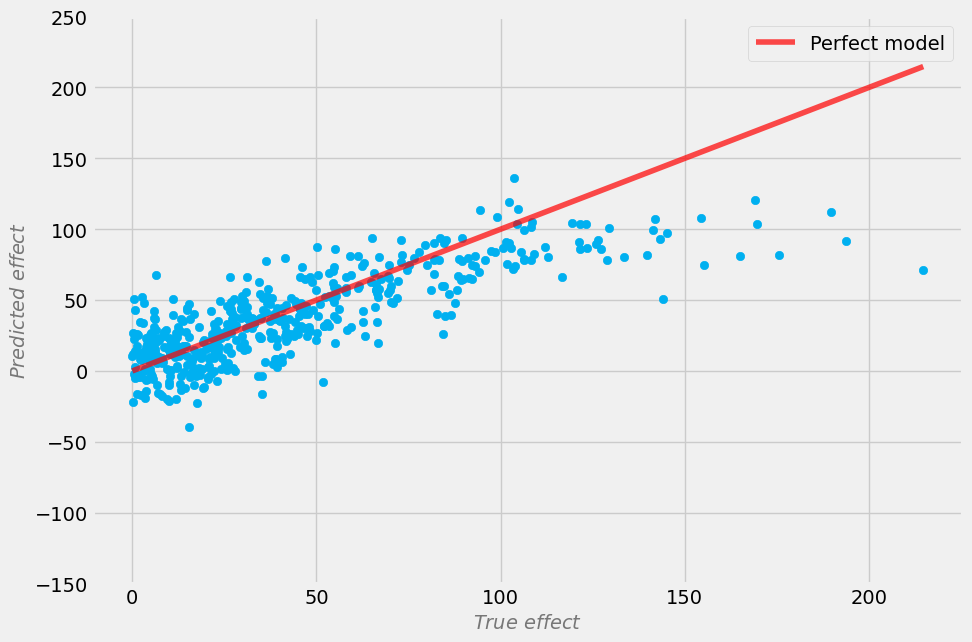

XLearner MAPE = 4.256912689213059


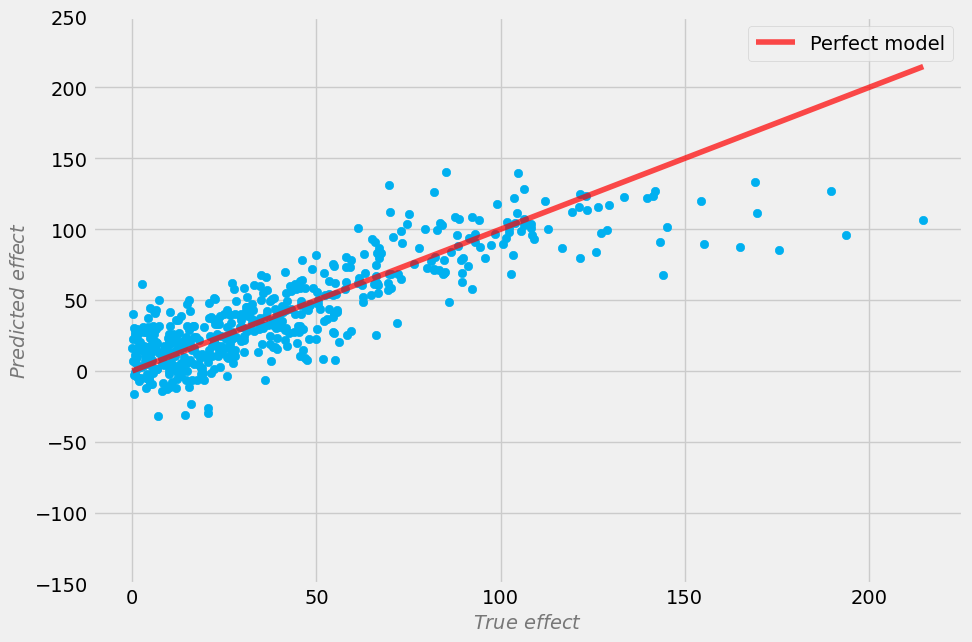

DRLearner MAPE = 8.642613444611401


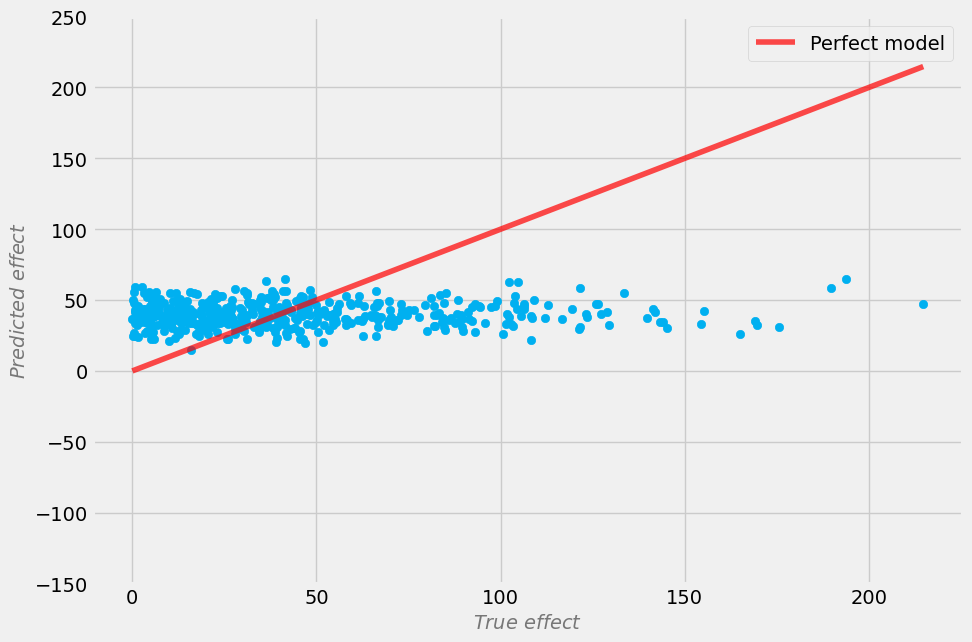

CausalForest MAPE = 3.231253507506816


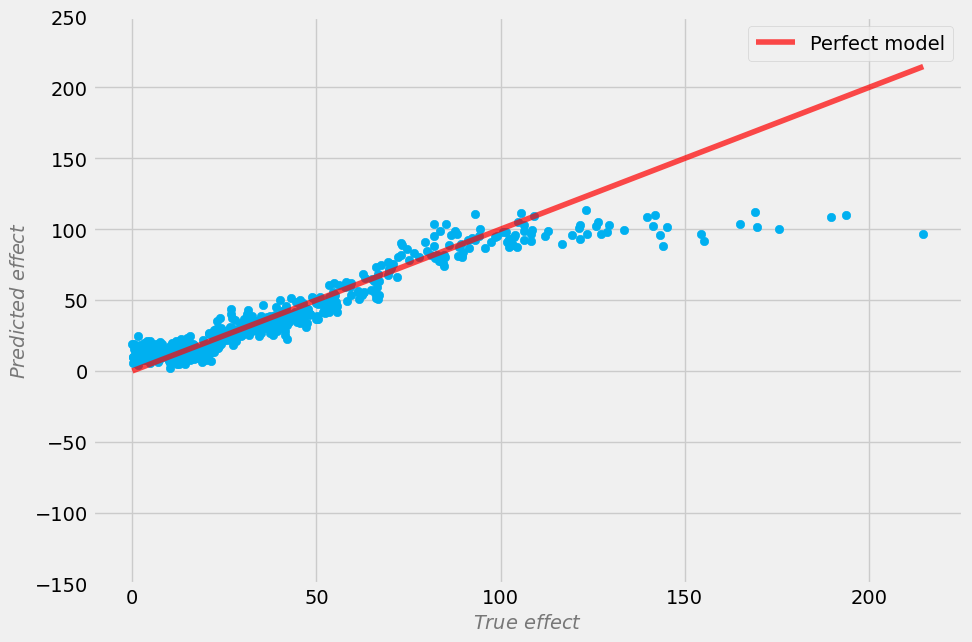

In [10]:
for model_name in benchmark_results.keys():
    effect_pred = benchmark_results[model_name]
    print(f'{model_name} MAPE = {mean_absolute_percentage_error(effect_true, effect_pred)}')
    
    plot_effect(
        effect_true=effect_true,
        effect_pred=effect_pred,
        ylim=(-150, 250)
    )

### TARNet

In [11]:
tarnet = TARNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin='selu',
)

tarnet.fit(
    X=X[:TRAIN_SIZE, :],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
);


In [12]:
# Get predictions
effect_pred_tarnet = tarnet.predict(
    X=X[TRAIN_SIZE:, :]
).cpu().detach().numpy()

In [13]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred_tarnet)

In [14]:
?mean_absolute_percentage_error

Signature:
mean_absolute_percentage_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
)
Docstring:
Mean absolute percentage error (MAPE) regression loss.

Note here that the output is not a percentage in the range [0, 100]
and a value of 100 does not mean 100% but 1e2. Furthermore, the output
can be arbitrarily high when `y_true` is small (which is specific to the
metric) or when `abs(y_true - y_pred)` is large (which is common for most
regression metrics). Read more in the
:ref:`User Guide <mean_absolute_percentage_error>`.

.. versionadded:: 0.24

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

multioutput : {'raw_values', 'uniform_average'} or array-like
    Defines aggregat

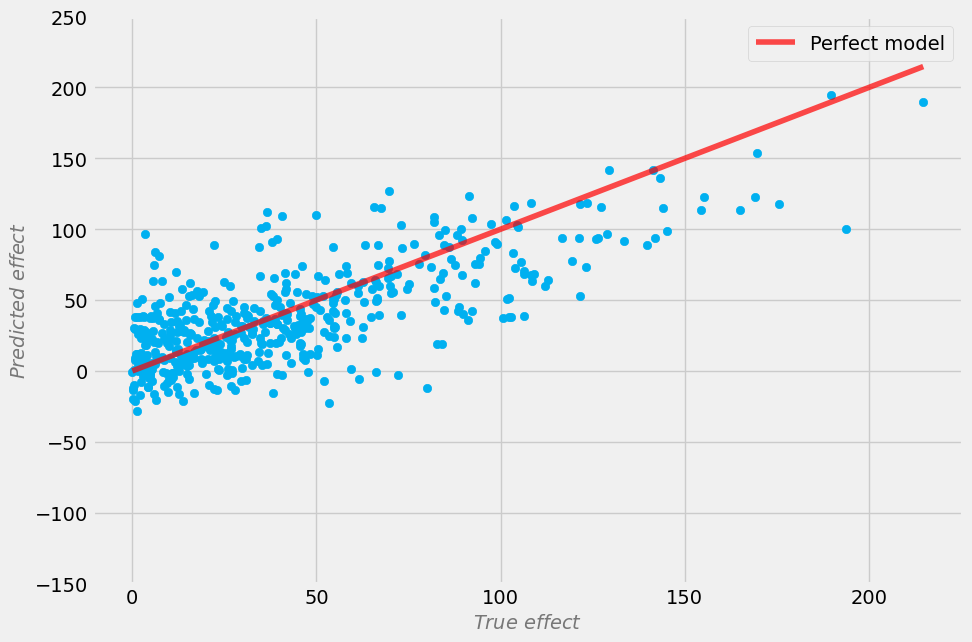

In [15]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred_tarnet,
    ylim=(-150, 250)
)

### SNet

In [16]:
snet = SNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin='selu',
)

snet.fit(
    X=X[:TRAIN_SIZE, :],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
);

In [17]:
effect_pred_snet = snet.predict(
    X=X[TRAIN_SIZE:, :]
).cpu().detach().numpy()

In [18]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred_snet)

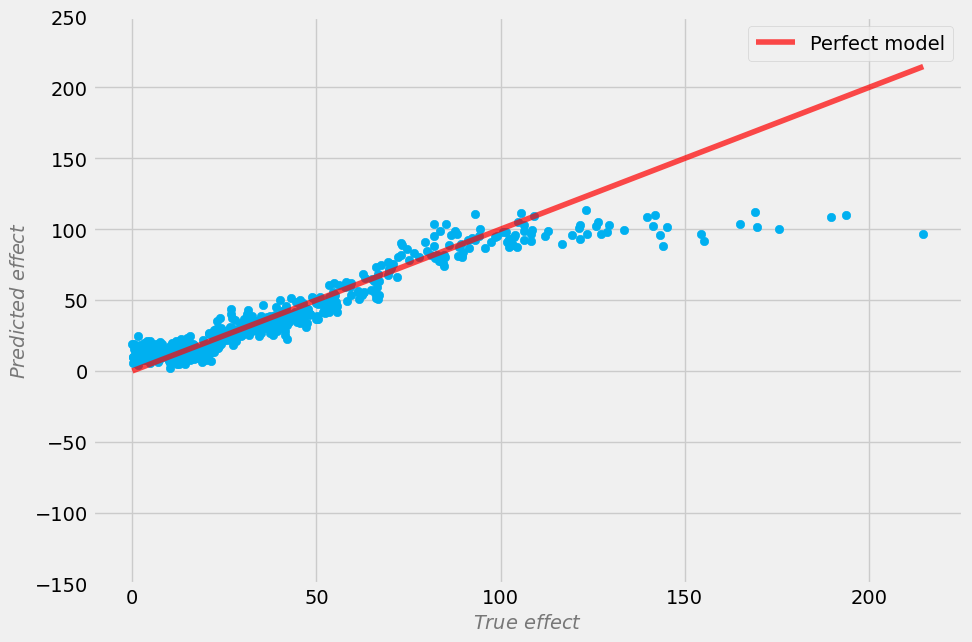

In [19]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
    ylim=(-150, 250)
)

## Transformers and Causal Inference

### Data

In [20]:
# Read-in
df = pd.read_csv('data/manga_processed.csv')          

In [21]:
# Shuffle observations
df = df.sample(frac=1)

In [22]:
df.head()

,text,subreddit,female_avatar,has_photo,upvote
217,I'm blown away by 'Hunter x Hunter' and its so...,manga,0,0,1
27,Can we talk about how 'Fushigi Yugi' has some ...,manga,1,0,0
22,Who else loves 'Nausicaä of the Valley of the ...,manga,1,1,1
102,Let's talk about 'Jojo's Bizarre Adventure' an...,manga,0,0,1
34,Can we talk about how 'A Silent Voice' tackles...,manga,0,0,0


In [23]:
df.shape

### Modeling

In [24]:
# Re-running the model training? Un-comment the lines below and collect garbarge to free the GPU memory
# import gc
# del causal_bert
# gc.collect()
# torch.cuda.empty_cache()

# torch.cuda.is_available()

In [25]:
# Instantiate the model
causal_bert = CausalBertWrapper(
    batch_size=8,                      
    g_weight=0.05, 
    Q_weight=1., 
    mlm_weight=0.05
)

Some weights of CausalBert were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.0.0.bias', 'g_cls.bias', 'Q_cls.1.2.weight', 'vocab_projector.weight', 'Q_cls.0.0.weight', 'g_cls.weight', 'Q_cls.1.2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Train
causal_bert.train(
    texts=df['text'], 
    confounds=df['has_photo'], 
    treatments=df['female_avatar'], 
    outcomes=df['upvote'], 
    epochs=6
);

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
100%|██████████| 28/28 [00:16<00:00,  1.66it/s]


In [27]:
# Predict
preds = causal_bert.inference(
    texts=df['text'],
    confounds=df['has_photo'], 
)[0]

100%|██████████| 28/28 [00:03<00:00,  8.86it/s]


In [28]:
# Compute ATE
np.mean(preds[:, 1] - preds[:, 0])